# 🎯 Ring Attractor Demo (XFADS)

This notebook demonstrates XFADS learning ring attractor dynamics from **contaminated observations** with external input perturbations.

In [1]:
# Startup configuration
startupMode = 'dev'

if startupMode == 'colab':
    %pip install --quiet pytorch-lightning hydra-core
    %pip install git+https://github.com/catniplab/xfads
    %git clone https://github.com/catniplab/xfads
    %cd xfads/examples/gauss_ring_example
    config_path = "../content/xfads/examples/gauss_ring_example"
elif startupMode == 'dev':
    import sys
    sys.path.append('../..') # add path for xfads root
    sys.path.append('../../..') # add path for analyze_ring_attractor

    %load_ext autoreload
    %autoreload 2
    config_path = ''

In [2]:
# Imports
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl

import xfads.utils as utils
import xfads.plot_utils as plot_utils

from hydra import compose, initialize
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from xfads.ssm_modules.dynamics import DenseGaussianDynamics
from xfads.ssm_modules.likelihoods import GaussianLikelihood
from xfads.ssm_modules.dynamics import DenseGaussianInitialCondition
from xfads.ssm_modules.encoders import LocalEncoderLRMvn, BackwardEncoderLRMvn
from xfads.smoothers.lightning_trainers import LightningNonlinearSSM
from xfads.smoothers.nonlinear_smoother import NonlinearFilterSmallL, LowRankNonlinearStateSpaceModel

## ⚙️ 2. Initialize Configuration

We use Hydra to load experiment configs and set up deterministic behavior for reproducibility.

In [3]:
from hydra.core.global_hydra import GlobalHydra
if GlobalHydra.instance().is_initialized():
    GlobalHydra.instance().clear()

initialize(version_base=None, config_path=config_path, job_name="contaminated_ring")
cfg = compose(config_name="config")

pl.seed_everything(cfg.seed, workers=True)
torch.set_default_dtype(torch.float32)
torch.cuda.empty_cache()

Seed set to 1234


In [4]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

cfg['device'] = device
print(f"Using device: {device}")

# A quick test
matrix_a = torch.randn(1024, 1024, device=device)
result = torch.matmul(matrix_a, matrix_a)

cfg['n_epochs'] = 50  # reduced epochs for demo

Using device: cpu


In [35]:
class GPPrior(nn.Module):
    """
    Simple zero-mean GP prior with RBF kernel using GPyTorch.
    """
    def __init__(self, train_x: torch.Tensor, lengthscale: float = 1.0, noise: float = 1e-6):
        super().__init__()
        self.mean_module = gpytorch.means.ZeroMean(batch_shape=torch.Size([2]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(lengthscale=lengthscale,batch_shape=torch.Size([2])),
            batch_shape=torch.Size([2]),
        )
        self.train_x = train_x
        # Jitter for numerical stability
        self.noise = noise

    def forward(self, x: torch.Tensor) -> gpytorch.distributions.MultivariateNormal:
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        # Add jitter to diagonal
        covar = covar_x + self.noise * torch.eye(x.size(0), device=x.device)
        return gpytorch.distributions.MultitaskMultivariateNormal.from_batch_mvn(
            gpytorch.distributions.MultivariateNormal(mean_x, covar))

class PerturbedVectorField(nn.Module):
    """
    PyTorch module for a perturbed radial-attractor vector field.

    Vector field:
        x' = x*(1 - ||x||_2) + perturb(x)

    The perturbation is a zero-mean GP sample on a grid, then bilinearly interpolated.
    """
    def __init__(
        self,
            bin_sz:Union[int,float] = 5e-3,
        perturbation_magnitude: float = 1.0,
        grid_size: Union[int, Tuple[int, int]] = 20,
        domain_extent: Union[Tuple[float, float], Tuple[Tuple[float, float], Tuple[float, float]]] = (-2.0, 2.0),
        lengthscale: float = 1.0,
        jitter: float = 1e-5
    ):
        super().__init__()
        self.perturbation_magnitude = perturbation_magnitude
        self.bin_sz = bin_sz

        # Build grid
        if isinstance(grid_size, int):
            Nx = Ny = grid_size
        else:
            Nx, Ny = grid_size

        if isinstance(domain_extent[0], (int, float)):
            d_min, d_max = domain_extent
            x_min, x_max = -abs(d_min), abs(d_max)
            y_min, y_max = -abs(d_min), abs(d_max)
        else:
            (x_min, x_max), (y_min, y_max) = domain_extent

        x_grid = np.linspace(x_min, x_max, Nx)
        y_grid = np.linspace(y_min, y_max, Ny)
        X, Y = np.meshgrid(x_grid, y_grid)
        pts = np.column_stack([X.ravel(), Y.ravel()])  # (Nx*Ny, 2)
        pts_t = torch.from_numpy(pts.astype(np.float32))

        # Sample GP prior for U and V components
        gp_model = GPPrior(train_x=pts_t, lengthscale=lengthscale, noise=jitter)
        gp_model.eval()
        UV_grid = gp_model(pts_t).sample()

        U_grid,V_grid = UV_grid.renorm(p=2,dim=1,maxnorm=perturbation_magnitude).vsplit(2)

        # Register buffers
        self.register_buffer('x_grid', torch.from_numpy(x_grid.astype(np.float32)))
        self.register_buffer('y_grid', torch.from_numpy(y_grid.astype(np.float32)))
        self.register_buffer('perturb_u', U_grid.unsqueeze(0).unsqueeze(0))
        self.register_buffer('perturb_v', V_grid.unsqueeze(0).unsqueeze(0))
        self.x_min, self.x_max = x_min, x_max
        self.y_min, self.y_max = y_min, y_max

    def _bilinear_interpolate(self, field: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        # Normalize to [-1,1]
        xi = 2 * (x[...,0] - self.x_min) / (self.x_max - self.x_min) - 1
        yi = 2 * (x[...,1] - self.y_min) / (self.y_max - self.y_min) - 1
        pts = torch.stack((xi, yi), dim=-1)
        pts = pts.unsqueeze(0).unsqueeze(0)
        sampled = F.grid_sample(field, pts, align_corners=True, mode='bilinear')
        return sampled.squeeze()

    def forward(self, x: torch.Tensor, t: Optional[torch.Tensor] = torch.tensor(0)) -> torch.Tensor:
        # Radial-attractor base field
        r = torch.norm(x, dim=-1, keepdim=True)
        base = x * (1 - r)
        # Perturbation
        u = self._bilinear_interpolate(self.perturb_u, x)
        v = self._bilinear_interpolate(self.perturb_v, x)
        perturb = torch.stack((u, v), dim=-1)
        return x + self.bin_sz * (base + perturb)

def sample_gauss_z(
    mean_fn: Callable[[torch.Tensor], torch.Tensor],
    Q_diag: torch.Tensor,
    m_0: torch.Tensor,
    Q_0_diag: torch.Tensor,
    n_trials: int,
    n_time_bins: int,
) -> torch.Tensor:
    device, dtype = Q_diag.device, Q_diag.dtype
    n_latents = Q_diag.shape[-1]
    z = torch.empty((n_trials, n_time_bins, n_latents), device=device)

    # Pre-sample all noise
    eps = torch.randn((n_trials, n_time_bins, n_latents), device=device)

    # First time step
    z[:, 0] = m_0 + eps[:, 0] * torch.sqrt(Q_0_diag)
    z_prev = torch.zeros(n_trials,n_latents,device=device,dtype=dtype)

    # Recursive sampling
    for t in range(1, n_time_bins):
        z_prev.copy_(z[:, t - 1])
        z[:, t] = mean_fn(z_prev) + eps[:, t] * torch.sqrt(Q_diag)

    return z

In [38]:
vb = PerturbedVectorField(perturbation_magnitude=0.0, bin_sz = 1e-1,
                              grid_size=(40),
                              domain_extent=(-3.0,3.0),
                              lengthscale=1.0)

# Create plotting grid
x = vb.x_grid.cpu().numpy()
y = vb.y_grid.cpu().numpy()
X, Y = np.meshgrid(x, y)
pts = np.column_stack([X.ravel(), Y.ravel()])
pts_t = torch.tensor(pts.astype(np.float32), requires_grad=True)

# Evaluate vector field
# with torch.no_grad():
vals = vb(pts_t)
U = vals[:,0].detach().numpy().reshape(Y.shape)
V = vals[:,1].detach().numpy().reshape(Y.shape)

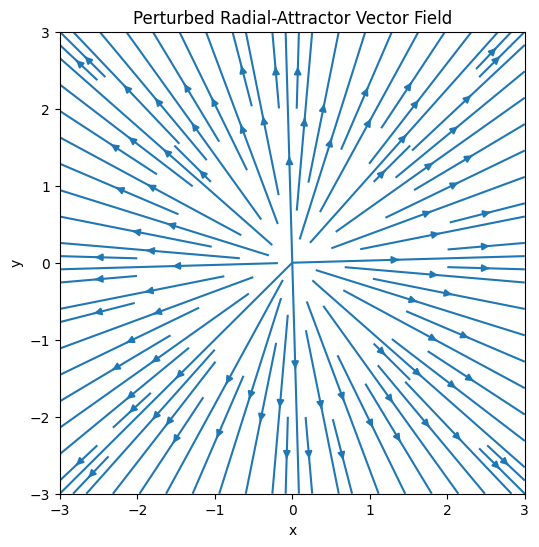

In [39]:
plt.figure(figsize=(6,6))
plt.streamplot(X, Y, U, V, density=1.2)
plt.title("Perturbed Radial-Attractor Vector Field")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## 📈 3. Simulate Ring Attractor Data

In [40]:
n_trials = 3000
n_neurons = 100
n_time_bins = 75

mean_fn = PerturbedVectorField(bin_sz = 1e-1)
C = utils.FanInLinear(cfg.n_latents, n_neurons, device=cfg.device).requires_grad_(False)

Q_diag = 5e-3 * torch.ones(cfg.n_latents, device=cfg.device)
Q_0_diag = 1.0 * torch.ones(cfg.n_latents, device=cfg.device)
R_diag = 1e-1 * torch.ones(n_neurons, device=cfg.device)
m_0 = torch.zeros(cfg.n_latents, device=cfg.device)

z = utils.sample_gauss_z(mean_fn, Q_diag, m_0, Q_0_diag, n_trials, n_time_bins)
y = C(z) + torch.sqrt(R_diag) * torch.randn((n_trials, n_time_bins, n_neurons), device=cfg.device)
y = y.detach()

In [48]:
z.shape

torch.Size([3000, 75, 2])

## 📈 4. Visualize Perturbed Data vs True Ring

Let's compare:
1. **True ring trajectories** (what we want to recover)
2. **External input patterns** (the contamination)
3. **Input distribution** across trials

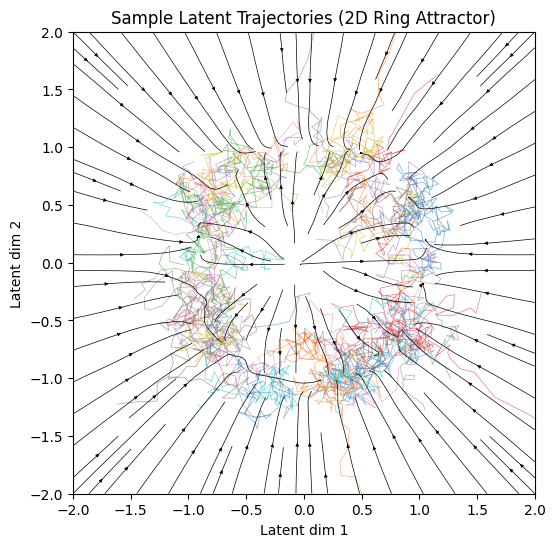

In [42]:
fig, axs = plt.subplots(figsize=(6, 6))
for i in range(40):
    axs.plot(z[i, :, 0].cpu(), z[i, :, 1].cpu(), alpha=0.6, linewidth=0.5)

plot_utils.plot_two_d_vector_field(mean_fn, axs, min_xy=-2, max_xy=2)
axs.set_title("Sample Latent Trajectories (2D Ring Attractor)")
axs.set_xlabel("Latent dim 1")
axs.set_ylabel("Latent dim 2")
axs.set_xlim(-2, 2)
axs.set_ylim(-2, 2)
axs.set_box_aspect(1.0)
plt.show()

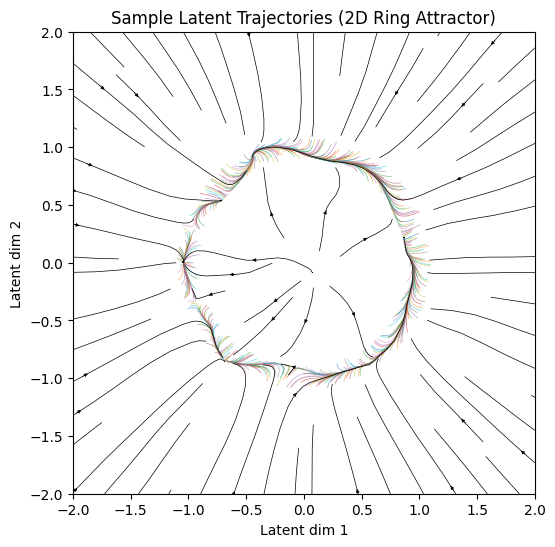

In [99]:
fig, axs = plt.subplots(figsize=(6, 6))
for i in range(500):
    axs.plot(z_true[i, :, 0], z_true[i, :, 1], alpha=0.6, linewidth=0.5)

# mean_fn = utils.RingAttractorDynamics(bin_sz=1e-1, w=0.0)
# plot_utils.plot_two_d_vector_field(mean_fn, axs, min_xy=-2, max_xy=2)

X, Y, u, v = true_vector_field.values()
axs.streamplot(X, Y, u, v, color='black', linewidth=0.5, arrowsize=0.5)

axs.set_title("Sample Latent Trajectories (2D Ring Attractor)")
axs.set_xlabel("Latent dim 1")
axs.set_ylabel("Latent dim 2")
axs.set_xlim(-2, 2)
axs.set_ylim(-2, 2)
axs.set_box_aspect(1.0)
plt.show()

In [43]:
from torch import Tensor
from typing import Callable, TypeAlias, Union
from functools import partial
import torchdiffeq

VectorField = Union[nn.Module, Callable[[Tensor], Tensor]]
nn_activation: TypeAlias = torch.nn.modules.activation
odeint = partial(torchdiffeq.odeint, options={"dtype":torch.float32})

class LieDerivative(nn.Module):
	"""
	Computes the Lie bracket [X, Y] = X·∇Y − Y·∇X of two vector fields X, Y : ℝⁿ → ℝⁿ,
	in a fully differentiable way.
	X, Y may be nn.Modules or plain callables.
	"""
	def __init__(self,
				 f: VectorField,
				 g: VectorField) -> None:
		super().__init__()

		if isinstance(f, nn.Module):
			self.X = f
		else:
			mod = nn.Module()
			mod.forward = f  # type: ignore[attr-defined]
			self.X = mod

		if isinstance(g, nn.Module):
			self.Y = g
		else:
			mod = nn.Module()
			mod.forward = g  # type: ignore[attr-defined]
			self.Y = mod

	def forward(self, x: Tensor) -> Tensor:

		f, g, x = self._eval_vfields(x)

		dg = torch.autograd.grad(
			outputs=g,
			inputs=x,
			grad_outputs=f,
			create_graph=True,
			retain_graph=True
		)[0]

		# directional derivative dX = ∇X(x) · Y_x
		df = torch.autograd.grad(
			outputs=f,
			inputs=x,
			grad_outputs=g,
			create_graph=True
		)[0]

		return dg - df

	def regularizer(self, x, *, normalize: bool = True) -> Tensor:
		f, g, x = self._eval_vfields(x)

		dg = torch.autograd.grad(
			outputs=g,
			inputs=x,
			grad_outputs=f,
			create_graph=True,
			retain_graph=True
		)[0]

		# directional derivative dX = ∇X(x) · Y_x
		df = torch.autograd.grad(
			outputs=f,
			inputs=x,
			grad_outputs=g,
			create_graph=True
		)[0]
		eps = torch.finfo(df.dtype).eps
		ell2 = torch.norm(dg - df,p=2, dim=-1)
		ell2 = torch.nn.functional.mse_loss(dg,df,reduction="sum")
		if normalize:
			dg.square().sum(dim=-1)
			dg_norm = dg.square().sum(dim=-1)
			return torch.sum(ell2/( dg_norm + eps))
		else:
			return torch.sum(ell2)

	def _eval_vfields(self, x):
		if not x.requires_grad:
			x = x.clone().detach().requires_grad_(True)
		f = self.X(x)
		g = self.Y(x)
		return f, g, x

In [44]:
y.shape
# n_trajs, n_timesteps, n_neurons

torch.Size([3000, 75, 100])

In [45]:
def dynamics_factory(A) -> Callable[[Tensor], Tensor]:
	def f(x: Tensor) -> Tensor:
		r = torch.sqrt(torch.sum((x @ A) * x, dim=-1, keepdim=True))
		return x * (1 - r)
	return f

In [49]:
A = torch.eye(2).requires_grad_(True)
f = dynamics_factory(A)

def v(x: Tensor) -> Tensor:
			return x @ torch.tensor([[0.0, -1.0], [1.0, 0.0]])

lie = LieDerivative(f, v)
ell = lie.regularizer(z)
print(f"Normalized Lie derivative loss: {ell.item():.3e} for ring-like dynamics\n")
grad_A, = torch.autograd.grad(ell, A, create_graph=False)
# print(grad_A)

z0 = z.detach().requires_grad_(True)
ell_1 = lie.regularizer(z0, normalize=False)
print(f"Unnormalized Lie derivative loss: {ell_1.item():.3e} for ring-like dynamics\n\n")
(grad_A1,) = torch.autograd.grad(ell_1, A)

Normalized Lie derivative loss: 3.500e+14 for ring-like dynamics

Unnormalized Lie derivative loss: 8.494e+04 for ring-like dynamics




## 🗂️ 5. Prepare Train/Validation Dataloaders

Split the contaminated data into training and validation sets.

**🔥 KEY POINT:** xFADS only sees the contaminated observations `y` - it doesn't know about the external inputs!

In [91]:
def collate_fn(batch):
    elem = batch[0]
    if isinstance(elem, (tuple, list)):
        return tuple(torch.stack([b[i] for b in batch]).to(cfg.device) for i in range(len(elem)))
    else:
        return torch.stack(batch).to(cfg.device)

# Split data
y_train, z_train = y[:2*n_trials//3], z_true[:2*n_trials//3]
y_valid, z_valid = y[2*n_trials//3:], z_true[2*n_trials//3:]

# Create dataloaders (only observations, no ground truth)
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(y_train), batch_size=cfg.batch_sz, shuffle=True, collate_fn=collate_fn
)
valid_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(y_valid), batch_size=cfg.batch_sz, shuffle=False, collate_fn=collate_fn
)

print(f"Training data: {y_train.shape} (contaminated observations only)")
print(f"Validation data: {y_valid.shape} (contaminated observations only)")
print(f"🚫 xFADS does NOT see: true latents, external inputs, or ring manifold")

Training data: torch.Size([333, 100, 50]) (contaminated observations only)
Validation data: torch.Size([167, 100, 50]) (contaminated observations only)
🚫 xFADS does NOT see: true latents, external inputs, or ring manifold


## 🧱 6. Define Model Components

We define the same xFADS architecture as the standard ring demo:
- A Gaussian likelihood with learnable readout
- A nonlinear Gaussian dynamics module  
- A prior over the initial condition
- Local and backward encoders for amortized inference

**The model has no knowledge of external inputs - it must learn to ignore them!**

In [92]:
# n_trials = 3000
# n_neurons = 100
# n_time_bins = 75

# Likelihood
C = utils.FanInLinear(cfg.n_latents, n_neurons, device=cfg.device)
H = utils.ReadoutLatentMask(cfg.n_latents, cfg.n_latents_read)
readout_fn = nn.Sequential(H, C)
R_diag = 1e-1 * torch.ones(n_neurons, device=cfg.device)
likelihood_pdf = GaussianLikelihood(readout_fn, n_neurons, R_diag, device=cfg.device, fix_R=True)

# Dynamics (this is what we want to recover despite contamination!)
dynamics_fn = utils.build_gru_dynamics_function(cfg.n_latents, cfg.n_hidden_dynamics, device=cfg.device)
Q_diag = 5e-3 * torch.ones(cfg.n_latents, device=cfg.device)
dynamics_mod = DenseGaussianDynamics(dynamics_fn, cfg.n_latents, Q_diag, device=cfg.device)

# Initial condition
m_0 = torch.zeros(cfg.n_latents, device=cfg.device)
Q_0_diag = 1.0 * torch.ones(cfg.n_latents, device=cfg.device)
initial_condition_pdf = DenseGaussianInitialCondition(cfg.n_latents, m_0, Q_0_diag, device=cfg.device)

# Encoders
backward_encoder = BackwardEncoderLRMvn(
    cfg.n_latents, cfg.n_hidden_backward, cfg.n_latents,
    rank_local=cfg.rank_local, rank_backward=cfg.rank_backward, device=cfg.device
)
local_encoder = LocalEncoderLRMvn(
    cfg.n_latents, n_neurons, cfg.n_hidden_local, cfg.n_latents,
    rank=cfg.rank_local, device=cfg.device, dropout=cfg.p_local_dropout
)

# Nonlinear filtering
nl_filter = NonlinearFilterSmallL(dynamics_mod, initial_condition_pdf, device=cfg.device)

print(f"✅ Model components defined for {n_neurons}D→{cfg.n_latents}D mapping")
print(f"🎯 Challenge: Learn ring dynamics from {n_neurons}D contaminated observations")

✅ Model components defined for 50D→2D mapping
🎯 Challenge: Learn ring dynamics from 50D contaminated observations


## 🧠 7. Assemble the State Space Model

We combine dynamics, likelihood, encoders, and filtering into a complete latent variable model.

In [93]:
ssm = LowRankNonlinearStateSpaceModel(
    dynamics_mod, likelihood_pdf, initial_condition_pdf,
    backward_encoder, local_encoder, nl_filter, device=cfg.device
)

print("✅ Complete xFADS model assembled")
print("🎯 Ready to learn ring dynamics from contaminated observations")

✅ Complete xFADS model assembled
🎯 Ready to learn ring dynamics from contaminated observations


## 🔁 8. Train the Model Using PyTorch Lightning

We use `LightningNonlinearSSM` for training. The model will attempt to:
1. **Learn the true ring attractor dynamics** 
2. **Recover clean latent trajectories**

In [94]:
from pytorch_lightning.callbacks import Timer
timer = Timer()

In [96]:
train_from_scratch = True # Set to False to load pre-trained model

if train_from_scratch:
    seq_vae = LightningNonlinearSSM(ssm, cfg)

    csv_logger = CSVLogger('logs/', name='contaminated_ring', version='demo')
    ckpt_callback = ModelCheckpoint(
        save_top_k=3, monitor='valid_loss', mode='min',
        dirpath='ckpts/', filename='demo_{epoch:0}_{valid_loss:.2f}'
    )

    trainer = pl.Trainer(
        max_epochs=cfg.n_epochs,
        gradient_clip_val=1.0,
        default_root_dir='lightning/',
        callbacks=[ckpt_callback, timer],
        accelerator=cfg.device,
        logger=csv_logger
    )

    print("🚀 Starting training on contaminated ring attractor data...")
    print("🎯 Goal: Recover true ring dynamics despite external input interference")
    
    trainer.fit(model=seq_vae, train_dataloaders=train_loader, val_dataloaders=valid_loader)
    torch.save(ckpt_callback.best_model_path, 'ckpts/best_demo_model.pt')
    
    print("✅ Training completed!")

else:
    # Load pre-trained model (update path as needed)
    # seq_vae = LightningNonlinearSSM.load_from_checkpoint('/Users/artliang/Documents/symm_reg/xfads/examples/ring_attractor/ckpts/example_model.ckpt', ssm=ssm, cfg=cfg)
    seq_vae = LightningNonlinearSSM.load_from_checkpoint('/Users/artliang/Documents/symm_reg/xfads/examples/gauss_ring_example/ckpts/demo_epoch=18_valid_loss=5800.98.ckpt', ssm=ssm, cfg=cfg)
    print("✅ Loaded pre-trained model")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type                            | Params
---------------------------------------------------------
0 | ssm  | LowRankNonlinearStateSpaceModel | 34.7 K
---------------------------------------------------------
34.7 K    Trainable params
0         Non-trainable params
34.7 K    Total params
0.139     Total estimated model params size (MB)


🚀 Starting training on contaminated ring attractor data...
🎯 Goal: Recover true ring dynamics despite external input interference
Epoch 0: 100%|██████████| 3/3 [00:09<00:00,  0.33it/s, v_num=demo]tensor(6778.0737)
tensor(5869.2554)
Epoch 1: 100%|██████████| 3/3 [00:10<00:00,  0.28it/s, v_num=demo, valid_loss=6.57e+3, train_loss=3.94e+3, time_forward=1.720]tensor(8492.1289)
tensor(6487.1201)
Epoch 2: 100%|██████████| 3/3 [00:08<00:00,  0.35it/s, v_num=demo, valid_loss=8.02e+3, train_loss=3.05e+3, time_forward=1.970]tensor(7203.8540)
tensor(5901.9395)
Epoch 3:  33%|███▎      | 1/3 [00:03<00:06,  0.32it/s, v_num=demo, valid_loss=6.9e+3, train_loss=3.05e+3, time_forward=1.610]tensor(2756.1746, grad_fn=<MeanBackward0>)
✅ Training completed!


In [17]:
if train_from_scratch:
    print(f"⏱️ Total training time: {timer.time_elapsed('train')}")
    print(f"⏱️ Validation time: {timer.time_elapsed('validate')}")

## 🌀 9. Analyze Learned Dynamics vs True Ring

Now the critical test: Did xFADS learn the true ring attractor dynamics despite the input contamination?

We'll compare:
1. **True ring vector field** (ground truth)
2. **Learned dynamics** (what xFADS recovered)
3. **Inferred trajectories** vs **true trajectories**

In [ ]:
# Infer latent trajectories from contaminated observations
seq_vae.eval()
with torch.no_grad():
    _, z_inferred_samples, _ = seq_vae.ssm(y, cfg.n_samples)
    z_inferred = z_inferred_samples.mean(dim=0)

print(f"✅ Inferred latents from contaminated observations")
print(f"   Inferred shape: {z_inferred.shape}")
print(f"   True shape: {z_true.shape}")

# Compute basic metrics
mse = torch.mean((z_inferred - z_true)**2).item()
correlation = torch.corrcoef(torch.stack([z_true.flatten(), z_inferred.flatten()]))[0, 1].item()

print(f"📊 Recovery metrics:")
print(f"   MSE: {mse:.6f}")
print(f"   Correlation: {correlation:.4f}")

✅ Inferred latents from contaminated observations
   Inferred shape: torch.Size([500, 100, 2])
   True shape: torch.Size([500, 100, 2])
📊 Recovery metrics:
   MSE: 0.495936
   Correlation: -0.0021


### 🧭 Compare True vs Learned Vector Fields

The ultimate test: Does the learned dynamics match the true ring attractor?

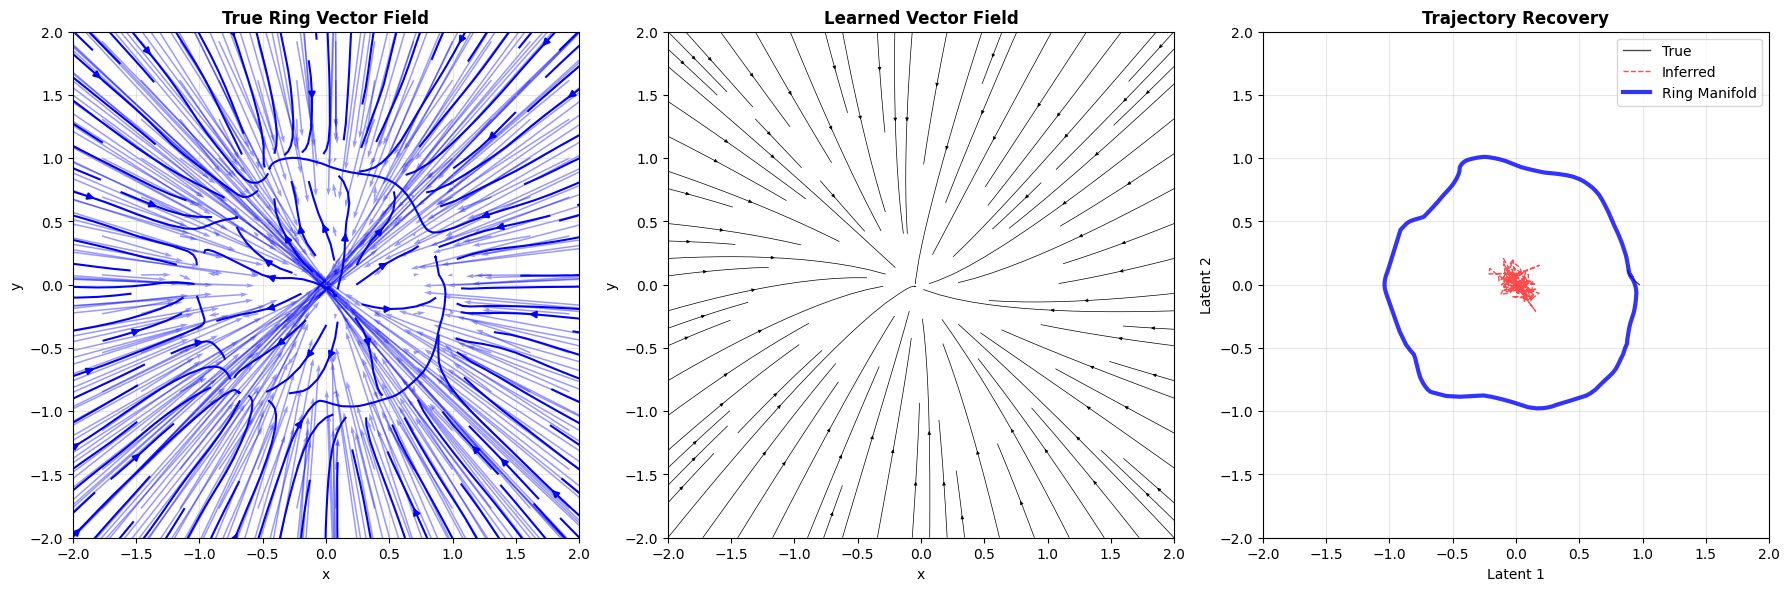

🎯 ANALYSIS: How well did xFADS recover the true ring dynamics?
   Compare left (true) vs middle (learned) vector fields
   Right plot shows trajectory recovery quality


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: True vector field (if available)
if true_vector_field is not None:
    ax = axes[0]
    true_X = true_vector_field['X'].numpy() if torch.is_tensor(true_vector_field['X']) else true_vector_field['X']
    true_Y = true_vector_field['Y'].numpy() if torch.is_tensor(true_vector_field['Y']) else true_vector_field['Y']
    true_U = true_vector_field['U'].numpy() if torch.is_tensor(true_vector_field['U']) else true_vector_field['U']
    true_V = true_vector_field['V'].numpy() if torch.is_tensor(true_vector_field['V']) else true_vector_field['V']
    
    ax.streamplot(true_X, true_Y, true_U, true_V, density=1.5, color='blue')
    ax.quiver(true_X[::2, ::2], true_Y[::2, ::2], true_U[::2, ::2], true_V[::2, ::2], 
              color='blue', alpha=0.4, scale=10)
    ax.set_title('True Ring Vector Field', fontweight='bold')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
else:
    axes[0].text(0.5, 0.5, 'True vector field\nnot available', 
                transform=axes[0].transAxes, ha='center', va='center')
    axes[0].set_title('True Ring Vector Field')

# Plot 2: Learned vector field
ax = axes[1]
plot_utils.plot_two_d_vector_field(
    seq_vae.ssm.dynamics_mod.mean_fn, ax, min_xy=-2, max_xy=2
)
ax.set_title('Learned Vector Field', fontweight='bold')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')

# Plot 3: Trajectory comparison
ax = axes[2]
for i in range(1):
    ax.plot(z_true[i, :, 0], z_true[i, :, 1], 'k-', alpha=0.7, linewidth=1, 
           label='True' if i == 0 else None)
    ax.plot(z_inferred[i, :, 0], z_inferred[i, :, 1], 'r--', alpha=0.7, linewidth=1,
           label='Inferred' if i == 0 else None)

# Plot ring manifold
ax.plot(inv_man[:, 0], inv_man[:, 1], 'b-', linewidth=3, alpha=0.8, label='Ring Manifold')
ax.set_title('Trajectory Recovery', fontweight='bold')
ax.set_xlabel('Latent 1')
ax.set_ylabel('Latent 2')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 🎲 Test Learned Dynamics with Autonomous Rollouts

Generate new trajectories using only the learned dynamics (no observations).
This tests if the learned dynamics can autonomously generate ring-like behavior.

In [77]:
# Define rollout parameters
n_ex_samples = 1
n_ex_trials = 50
n_ex_time_bins = 100

# Sample initial latent states with varying amplitudes
z_0 = torch.zeros((n_ex_samples, n_ex_trials, 2))
z_0[:, ::2] = 0.2 * torch.randn_like(z_0[:, ::2])   # small amplitude
z_0[:, 1::2] = 1.5 * torch.randn_like(z_0[:, 1::2])  # large amplitude

# Predict forward using learned dynamics only
with torch.no_grad():
    z_rollout = seq_vae.ssm.predict_forward(z_0, n_ex_time_bins).detach()

print(f"✅ Generated autonomous rollouts from learned dynamics")
print(f"   Rollout shape: {z_rollout.shape}")

✅ Generated autonomous rollouts from learned dynamics
   Rollout shape: torch.Size([1, 50, 100, 2])


### 🎨 Final Comparison: Learned Dynamics + Autonomous Trajectories

The ultimate test of success: Do autonomous rollouts from the learned dynamics produce ring attractor behavior?

/var/folders/20/sydjdg052fld_b2zzxcwvf540000gn/T/ipykernel_32096/533733192.py:29: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/artliang/miniconda3/envs/xfads/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


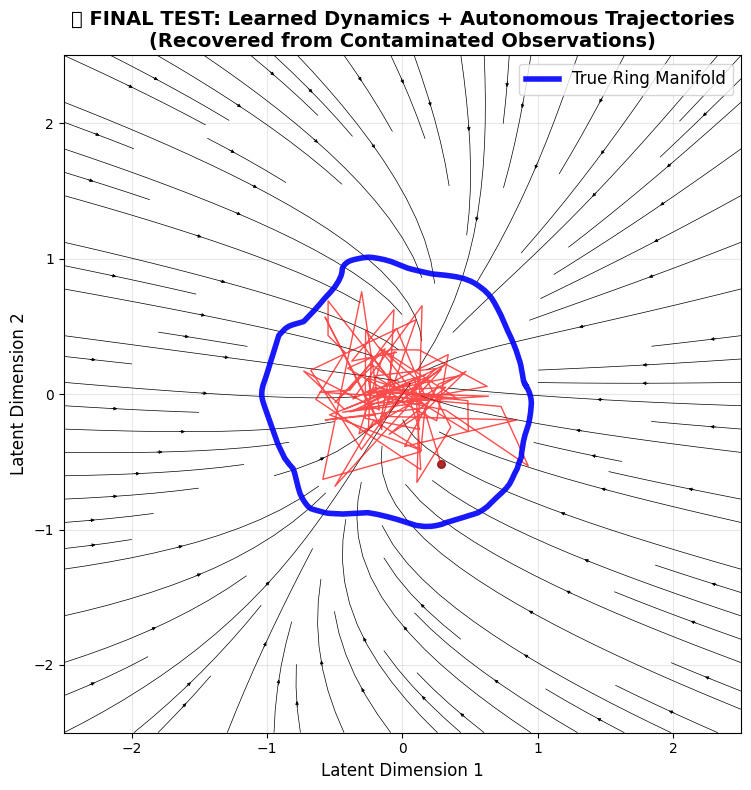

In [97]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_box_aspect(1.0)
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set_title("🎯 FINAL TEST: Learned Dynamics + Autonomous Trajectories\n" + 
            "(Recovered from Contaminated Observations)", fontweight='bold', fontsize=14)

# Plot learned vector field
plot_utils.plot_two_d_vector_field(
    seq_vae.ssm.dynamics_mod.mean_fn, ax, min_xy=-2.5, max_xy=2.5
)

# Overlay autonomous trajectories from learned dynamics
for i in range(1):  # plot subset for clarity
    ax.plot(z_rollout[0, i, :, 0].cpu(), z_rollout[0, i, :, 1].cpu(), 
           lw=1, alpha=0.7, color='red')
    # Mark starting points
    ax.scatter(z_rollout[0, i, 0, 0].cpu(), z_rollout[0, i, 0, 1].cpu(), 
              s=30, alpha=0.8, color='darkred')

# Plot true ring manifold for reference
ax.plot(inv_man[:, 0], inv_man[:, 1], 'b-', linewidth=4, alpha=0.9, label='True Ring Manifold')

ax.set_xlabel('Latent Dimension 1', fontsize=12)
ax.set_ylabel('Latent Dimension 2', fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()